In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prasad22/healthcare-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'healthcare-dataset' dataset.
Path to dataset files: /kaggle/input/healthcare-dataset


In [3]:
import os
import pandas as pd

# Listar archivos que hay dentro del dataset descargado
print("Archivos dentro del dataset:")
print(os.listdir(path))


csv_file = os.path.join(path, "healthcare_dataset.csv")

# Leer el CSV con pandas
df = pd.read_csv(csv_file)

# Mostrar las primeras filas
print(df.head())


Archivos dentro del dataset:
['healthcare_dataset.csv']
            Name  Age  Gender Blood Type Medical Condition Date of Admission  \
0  Bobby JacksOn   30    Male         B-            Cancer        2024-01-31   
1   LesLie TErRy   62    Male         A+           Obesity        2019-08-20   
2    DaNnY sMitH   76  Female         A-           Obesity        2022-09-22   
3   andrEw waTtS   28  Female         O+          Diabetes        2020-11-18   
4  adrIENNE bEll   43  Female        AB+            Cancer        2022-09-19   

             Doctor                    Hospital Insurance Provider  \
0     Matthew Smith             Sons and Miller         Blue Cross   
1   Samantha Davies                     Kim Inc           Medicare   
2  Tiffany Mitchell                    Cook PLC              Aetna   
3       Kevin Wells  Hernandez Rogers and Vang,           Medicare   
4    Kathleen Hanna                 White-White              Aetna   

   Billing Amount  Room Number Admission T

In [4]:
# Resumen básico del dataset
print("Dimensiones del dataset:", df.shape)  # filas y columnas
print("\nColumnas y tipos de datos:")
print(df.dtypes)

print("\nValores nulos por columna:")
print(df.isnull().sum())

print("\nEstadísticas numéricas:")
print(df.describe())

print("\nEstadísticas categóricas:")
print(df.describe(include=['object']))


Dimensiones del dataset: (55500, 15)

Columnas y tipos de datos:
Name                   object
Age                     int64
Gender                 object
Blood Type             object
Medical Condition      object
Date of Admission      object
Doctor                 object
Hospital               object
Insurance Provider     object
Billing Amount        float64
Room Number             int64
Admission Type         object
Discharge Date         object
Medication             object
Test Results           object
dtype: object

Valores nulos por columna:
Name                  0
Age                   0
Gender                0
Blood Type            0
Medical Condition     0
Date of Admission     0
Doctor                0
Hospital              0
Insurance Provider    0
Billing Amount        0
Room Number           0
Admission Type        0
Discharge Date        0
Medication            0
Test Results          0
dtype: int64

Estadísticas numéricas:
                Age  Billing Amount   Room Nu

##1. Carga y limpieza inicial de columnas

Justificación:

**Name, Doctor, Hospital** → demasiadas categorías, sin valor predictivo fuerte. Se eliminan.

**Date of Admission, Discharge Date** → no sirven como texto, pero sí podemos extraer información de fechas (ejemplo: año, mes, día de la semana, duración de hospitalización).

**Room Number** → parece un identificador → se elimina.

In [6]:
# ===============================================
# 1. Carga y limpieza inicial de columnas
# ===============================================

print("\n=== 1. CARGA Y LIMPIEZA INICIAL ===")

# Cargar el dataset
df = pd.read_csv(path + "/healthcare_dataset.csv")
print("Dimensiones originales:", df.shape)

# Eliminar columnas poco útiles o con alta cardinalidad
df = df.drop(columns=["Name", "Doctor", "Hospital", "Room Number"])
print("Después de eliminar columnas irrelevantes:", df.shape)

# Convertir fechas
df["Date of Admission"] = pd.to_datetime(df["Date of Admission"])
df["Discharge Date"] = pd.to_datetime(df["Discharge Date"])

# Extraer información de fechas
df["Admission_Year"] = df["Date of Admission"].dt.year
df["Admission_Month"] = df["Date of Admission"].dt.month
df["Admission_DayOfWeek"] = df["Date of Admission"].dt.dayofweek
df["Stay_Duration"] = (df["Discharge Date"] - df["Date of Admission"]).dt.days

# Eliminar columnas originales de fecha
df = df.drop(columns=["Date of Admission", "Discharge Date"])

print("Columnas después de procesar fechas:", df.columns.tolist())
print(df.head(3))



=== 1. CARGA Y LIMPIEZA INICIAL ===
Dimensiones originales: (55500, 15)
Después de eliminar columnas irrelevantes: (55500, 11)
Columnas después de procesar fechas: ['Age', 'Gender', 'Blood Type', 'Medical Condition', 'Insurance Provider', 'Billing Amount', 'Admission Type', 'Medication', 'Test Results', 'Admission_Year', 'Admission_Month', 'Admission_DayOfWeek', 'Stay_Duration']
   Age  Gender Blood Type Medical Condition Insurance Provider  \
0   30    Male         B-            Cancer         Blue Cross   
1   62    Male         A+           Obesity           Medicare   
2   76  Female         A-           Obesity              Aetna   

   Billing Amount Admission Type   Medication  Test Results  Admission_Year  \
0    18856.281306         Urgent  Paracetamol        Normal            2024   
1    33643.327287      Emergency    Ibuprofen  Inconclusive            2019   
2    27955.096079      Emergency      Aspirin        Normal            2022   

   Admission_Month  Admission_DayOf

##2. Codificación de variables categóricas

Justificación:

**Variables con pocas categorías (Gender, Blood Type, Medical Condition, Insurance Provider, Admission Type, Medication, Test Results)** → One-Hot Encoding para no introducir orden artificial.

In [7]:
# ===============================================
# 2. Codificación de variables categóricas
# ===============================================
from sklearn.preprocessing import OneHotEncoder

print("\n=== 2. CODIFICACIÓN DE VARIABLES CATEGÓRICAS ===")

categorical_cols = ["Gender", "Blood Type", "Medical Condition",
                    "Insurance Provider", "Admission Type",
                    "Medication", "Test Results"]

# Aplicar One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("Dimensiones después de One-Hot Encoding:", df_encoded.shape)
print("Columnas de ejemplo después del encoding:")
print([c for c in df_encoded.columns if "Gender" in c or "Blood Type" in c][:10])
print(df_encoded.head(3))



=== 2. CODIFICACIÓN DE VARIABLES CATEGÓRICAS ===
Dimensiones después de One-Hot Encoding: (55500, 31)
Columnas de ejemplo después del encoding:
['Gender_Male', 'Blood Type_A-', 'Blood Type_AB+', 'Blood Type_AB-', 'Blood Type_B+', 'Blood Type_B-', 'Blood Type_O+', 'Blood Type_O-']
   Age  Billing Amount  Admission_Year  Admission_Month  Admission_DayOfWeek  \
0   30    18856.281306            2024                1                    2   
1   62    33643.327287            2019                8                    1   
2   76    27955.096079            2022                9                    3   

   Stay_Duration  Gender_Male  Blood Type_A-  Blood Type_AB+  Blood Type_AB-  \
0              2         True          False           False           False   
1              6         True          False           False           False   
2             15        False           True           False           False   

   ...  Insurance Provider_Medicare  Insurance Provider_UnitedHealthcare  \


##3. Escalado de variables numéricas

Justificación:

**Age** → distribución normal → StandardScaler.

**Billing Amount**→ tiene valores negativos/outliers → RobustScaler.

**Stay_Duration y variables de fecha** → no tienen outliers extremos → StandardScaler.

In [8]:
# ===============================================
# 3. Escalado de variables numéricas
# ===============================================
from sklearn.preprocessing import StandardScaler, RobustScaler

print("\n=== 3. ESCALADO DE VARIABLES NUMÉRICAS ===")

df_scaled = df_encoded.copy()

# Escalar Age, Stay_Duration y variables temporales con StandardScaler
scaler_standard = StandardScaler()
df_scaled[["Age", "Stay_Duration", "Admission_Year",
           "Admission_Month", "Admission_DayOfWeek"]] = \
    scaler_standard.fit_transform(
        df_scaled[["Age", "Stay_Duration", "Admission_Year",
                   "Admission_Month", "Admission_DayOfWeek"]]
    )

# Escalar Billing Amount con RobustScaler
scaler_robust = RobustScaler()
df_scaled[["Billing Amount"]] = scaler_robust.fit_transform(df_scaled[["Billing Amount"]])

print("Escalado completado.")
print(df_scaled[["Age", "Billing Amount", "Stay_Duration"]].head(5))



=== 3. ESCALADO DE VARIABLES NUMÉRICAS ===
Escalado completado.
        Age  Billing Amount  Stay_Duration
0 -1.098824       -0.271846      -1.560018
1  0.533639        0.329760      -1.098099
2  1.247842        0.098336      -0.058780
3 -1.200853        0.503339       1.673417
4 -0.435636       -0.459727       0.518619


##4. Reducción de dimensionalidad

Justificación:

**PCA**→ mejor método para compactar muchas variables (sobre todo después del One-Hot).

Se seleccionan componentes que explican al menos 90–95% de la varianza.

**Para visualización** → reducimos a 2D.


=== 4. PCA ===
Número de componentes retenidos con 95% de varianza: 25


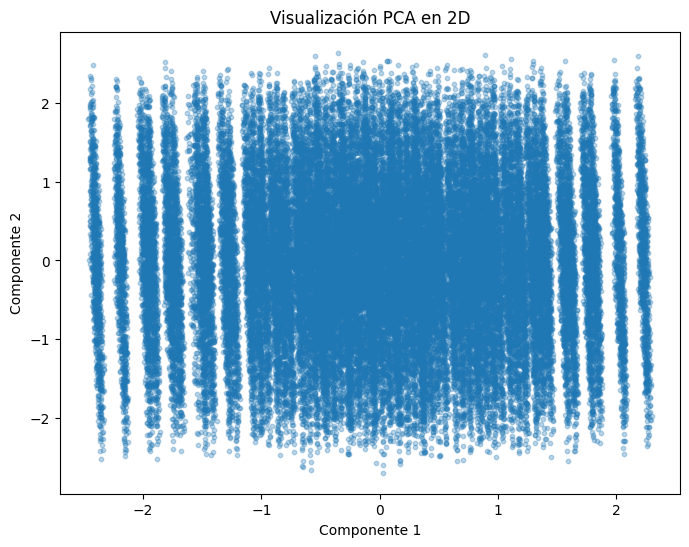

In [9]:
# ===============================================
# 4. Reducción de dimensionalidad con PCA
# ===============================================
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

print("\n=== 4. PCA ===")

# PCA manteniendo 95% de varianza
pca = PCA(n_components=0.95)
df_pca = pca.fit_transform(df_scaled)

print("Número de componentes retenidos con 95% de varianza:", df_pca.shape[1])

# Visualización en 2D con PCA
pca_2d = PCA(n_components=2)
df_pca_2d = pca_2d.fit_transform(df_scaled)

plt.figure(figsize=(8,6))
plt.scatter(df_pca_2d[:,0], df_pca_2d[:,1], alpha=0.3, s=10)
plt.title("Visualización PCA en 2D")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()
